<a href="https://colab.research.google.com/github/LindholmLabs/Neural-Computing/blob/main/CS4287_Prj1_24293059_24273759_24284335.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lars Jacobs (24293059)
William Lindholm (24273759)
Patrick Vorreiter (24284335)



The code executes until the end without error. Running the entire notebook at once requires 64 GB of RAM which could result in out of memory error.

Original source of part of the code is from Lab in week 6 from the Neural Computing CS4287 module. This code originated from Chapter 4 in Gulli, Kapoor, and Pal. Deep Learning with TensorFlow 2 and Keras, 2ndEd. Packt Publishing 200, displaying a CNN model.

#**Loading the dataset**

The code to help us load the dataset from kaggle can be found using this link:

https://www.kaggle.com/discussions/general/74235

The dataset we used can be found using this link:

https://www.kaggle.com/datasets/rm1000/skin-cancer-isic-images

It is a dataset of 1800 benign files and 1500 malignant images of skin cancer. This means that we will try to solve a binary classification problem using a CNN model.

In [ ]:
# Needed libraries
!pip install kaggle;

from google.colab import files

files.upload()

! mkdir ~/.kaggle;
! cp kaggle.json ~/.kaggle/;
! chmod 600 ~/.kaggle/kaggle.json;
! kaggle datasets list
! kaggle datasets download -d rm1000/skin-cancer-isic-images;
! unzip skin-cancer-isic-images.zip;



Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                          title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
valakhorasani/mobile-device-usage-and-user-behavior-dataset  Mobile Device Usage and User Behavior Dataset       11KB  2024-09-28 20:21:12           8169        153  1.0              
lainguyn123/student-performance-factors                      Student Performance Factors                         94KB  2024-09-02 10:53:57          36626        644  1.0              
ankulsharma150/netflix-data-analysis                         Netflix Data Analysis                                1MB  2024-10-15 08:02:26           1350         24  

#**Importing Data**

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

benign_path = './benign'
malignant_path = './malignant'

# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path)
        images.append(img)
    return images

benign_images = load_images_from_folder(benign_path)
malignant_images = load_images_from_folder(malignant_path)


#**Visualization**

For Data visualisation we decided to first of all show some of the example images that will be inputted into the CNN. We show 5 benign and 5 malignant photos.

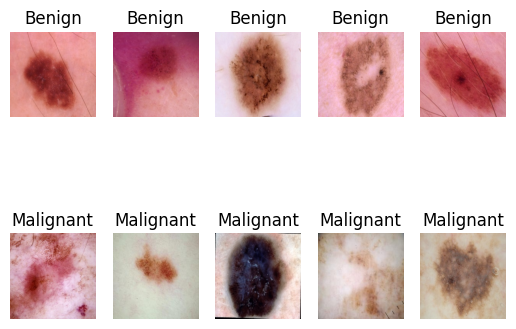

<Figure size 1000x500 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(benign_images[i])
    plt.title('Benign')
    plt.axis('off')

for i in range(5):
    plt.subplot(2, 5, i+6)
    plt.imshow(malignant_images[i])
    plt.title('Malignant')
    plt.axis('off')

plt.figure(figsize=(10, 5))
plt.tight_layout()
plt.show()


To understand if we need to worry about class imbalance, we plotted the distribution of both classes. The differences are relatively minor, but something that should optimally be accounted for. Since bias towards a benign outcome could be fatal in a medical setting.

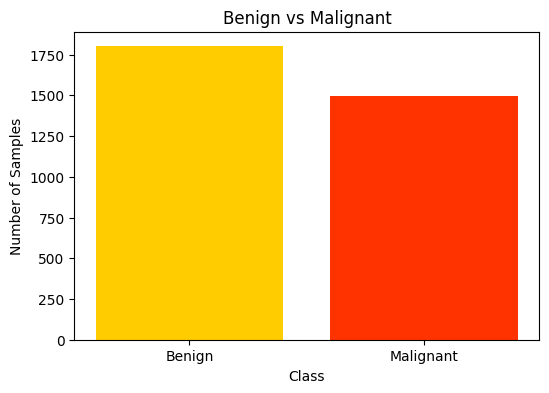

In [ ]:
num_benign = len(benign_images)
num_malignant = len(malignant_images)

plt.figure(figsize=(6, 4))
plt.bar(['Benign', 'Malignant'], [num_benign, num_malignant], color=['#ffcc00', '#ff3300'])
plt.title('Benign vs Malignant')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()


Finally, to see if the data is seperable, we plotted a heatmap containing the pixel intensity for every picture. This shows us partly how much every picture between the benign and malignant classes differs from each other.

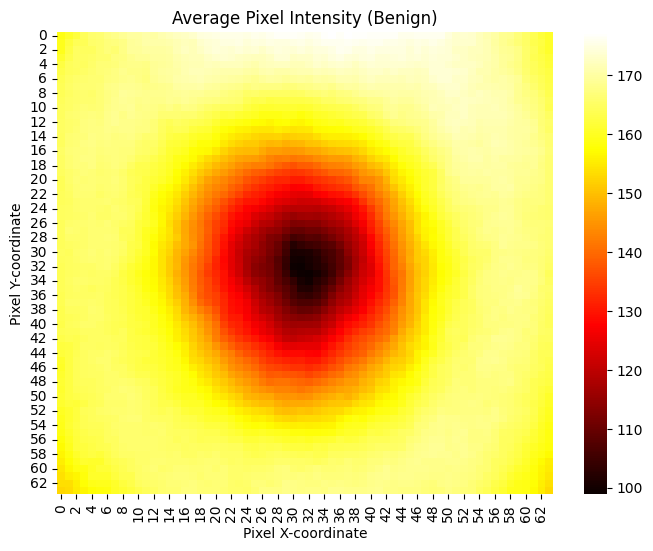

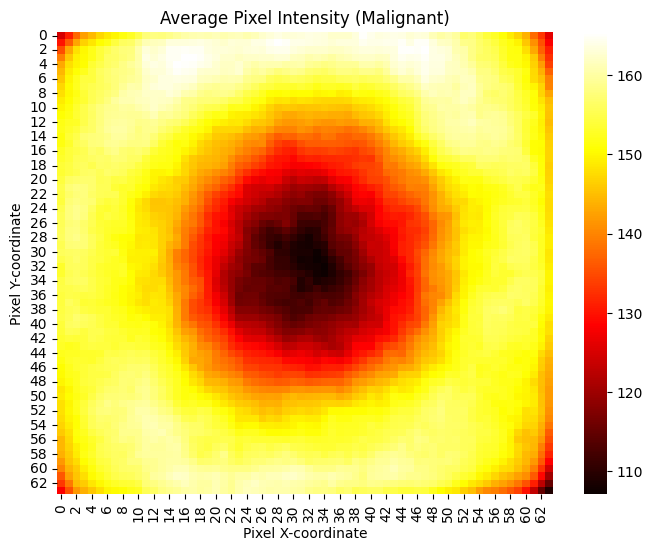

In [ ]:
import numpy as np
import seaborn as sns
import random
from PIL import Image

def compute_average_pixel_intensity(images, target_size=(64, 64)):
    avg_intensity = np.zeros(target_size)
    for img in images:
        img_resized = img.resize(target_size)
        img_array = np.array(img_resized.convert('L'))
        avg_intensity += img_array
    avg_intensity /= len(images)
    return avg_intensity

# Sample 100 images randomly
benign_sampled = random.sample(benign_images, min(100, len(benign_images)))
malignant_sampled = random.sample(malignant_images, min(100, len(malignant_images)))

# Compute average pixel intensity for the sampled images using the function provided before
avg_intensity_benign = compute_average_pixel_intensity(benign_sampled)
avg_intensity_malignant = compute_average_pixel_intensity(malignant_sampled)

plt.figure(figsize=(8, 6))
sns.heatmap(avg_intensity_benign, cmap='hot', cbar=True)
plt.title("Average Pixel Intensity (Benign)")
plt.xlabel('Pixel X-coordinate')
plt.ylabel('Pixel Y-coordinate')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(avg_intensity_malignant, cmap='hot', cbar=True)
plt.title("Average Pixel Intensity (Malignant)")
plt.xlabel('Pixel X-coordinate')
plt.ylabel('Pixel Y-coordinate')
plt.show()

# Our model class

We have wrapped all the code from the lab into a class to allow us to easily change the hyperparameters for the model, as well as providing the same process of data loading, training, testing, and visualisation for every test we did. This ensures that our results can be compared without interference from other factors.

In [ ]:
from re import X
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping

class ImageClassificationModel:
    def __init__(self, optimizer='adam', loss_function='binary_crossentropy', activation_function='relu', output_activation_function='sigmoid', num_output_neurons=1, batch_size=64, epochs=20, strides=(2, 2), dilation=(1, 1), data_augmentation=None, num_folds=2):
        # Fixed parameters
        self.img_size = (228, 228)
        self.num_classes = 2 # malignant and benign
        self.test_size = 0.2 # the split between test data and training data


        # Customizable parameters
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.activation_function = activation_function
        self.batch_size = batch_size
        self.epochs = epochs
        self.output_activation_function = output_activation_function
        self.data_augmentation = data_augmentation
        self.model_summary = False
        self.training_progress = 0
        self.num_output_neurons = num_output_neurons
        self.strides = strides
        self.dilation = dilation
        self.num_folds = num_folds

    # print the model summary
    def show_model_summary(self):
        self.model_summary = True

    # show the training progress
    def show_training_progress(self):
        self.training_progress = 1

    # Function to resize and normalize images
    def preprocess_images(self, images):
        images_resized = np.array([tf.image.resize(img, self.img_size).numpy() for img in images]) # The images are already all 228x228 so this step is not strictly necessay, but there for redundancy
        images_resized = images_resized.astype('float32') / 255.0 # Normalize images
        return images_resized

    # Function to load data, preprocess, and split into train and test sets
    def load_data(self, benign_images, malignant_images):
        benign_images_array = self.preprocess_images(benign_images)
        malignant_images_array = self.preprocess_images(malignant_images)

        benign_labels = np.zeros(len(benign_images_array)) # assign the label 0 to all benign skin cancer images
        malignant_labels = np.ones(len(malignant_images_array)) # assign the label 1 to all malignant skin cancer images

        # Combine images and corresponding labels into single arrays
        X_data = np.concatenate((benign_images_array, malignant_images_array), axis=0)
        y_data = np.concatenate((benign_labels, malignant_labels), axis=0)

        # Shuffle the dataset to randomize the order of images and labels
        indices = np.arange(X_data.shape[0]) # shuffle using index to make sure the labels are shuffled the same way as the images
        np.random.shuffle(indices)
        X_data = X_data[indices]
        y_data = y_data[indices]

        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=self.test_size, random_state=42) # Ensure that the split is same every time

        # if the number of output neurons is more than 1, it is categorical
        if self.num_output_neurons > 1:
            y_train = tf.keras.utils.to_categorical(y_train, self.num_classes)
            y_test = tf.keras.utils.to_categorical(y_test, self.num_classes)

        return X_train, y_train, X_test, y_test

    # Function to build the model
    def build_model(self, input_shape):
        model = models.Sequential()

        # Input layer
        model.add(layers.Input(shape=input_shape))

        # Below code from cifar-10 lab in lab4

        # 1st block
        model.add(layers.Conv2D(32, (3, 3), strides=self.strides, dilation_rate=self.dilation, padding='same', activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.2))

        # 2nd block
        model.add(layers.Conv2D(64, (3, 3), strides=self.strides, dilation_rate=self.dilation, padding='same', activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(64, (3, 3), strides=self.strides, dilation_rate=self.dilation, padding='same', activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.3))

        # 3rd block
        model.add(layers.Conv2D(128, (3, 3), strides=self.strides, dilation_rate=self.dilation, padding='same', activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(128, (3, 3), strides=self.strides, dilation_rate=self.dilation, padding='same', activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.4))

        # Dense layer
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation=self.activation_function))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(self.num_output_neurons, activation=self.output_activation_function))

        return model

    # Function to compile and train the model using the preset parameters and k crossfold validation
    def train_model(self, X_data, y_data):
        # Split data into k (num_folds) equal parts
        kf = KFold(n_splits=self.num_folds)
        fold_models = []
        fold_histories = []

        # train on fold
        for fold, (train_index, val_index) in enumerate(kf.split(X_data)):
            X_train, X_val = X_data[train_index], X_data[val_index]
            y_train, y_val = y_data[train_index], y_data[val_index]

            model = self.build_model(X_train.shape[1:])

            model.compile(optimizer=self.optimizer, loss=self.loss_function, metrics=['accuracy'])

            if self.model_summary:
                model.summary()

            if self.data_augmentation:
                history = model.fit(self.data_augmentation.flow(X_train, y_train, batch_size=self.batch_size),
                                    epochs=self.epochs, validation_data=(X_val, y_val),
                                    verbose=self.training_progress)
            else:
                history = model.fit(X_train, y_train, batch_size=self.batch_size, epochs=self.epochs,
                                    validation_data=(X_val, y_val), verbose=self.training_progress)

            # Store the model and history for this fold
            fold_models.append(model)
            fold_histories.append(history)

            # Optionally evaluate on the validation set
            val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
            print(f"Fold {fold + 1} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        return fold_models, fold_histories  # Return lists of models and histories

    # Function to evaluate the model on test data
    def evaluate_model(self, models, X_test, y_test):
        all_y_true = []
        all_y_pred = []

        # Loop through each model to get predictions
        for model in models:
            # For binary classification with sigmoid output:
            if self.num_output_neurons == 1:
                y_pred_prob = model.predict(X_test)
                y_pred = (y_pred_prob > 0.5).astype(int)  # Binary predictions (0 or 1)
                y_true = y_test  # No need to use argmax for binary classification
            # For multi-class classification with softmax output:
            else:
                y_pred_prob = model.predict(X_test)
                y_pred = np.argmax(y_pred_prob, axis=1)
                y_true = np.argmax(y_test, axis=1)

            # Store true and predicted labels
            all_y_true.extend(y_true)
            all_y_pred.extend(y_pred)

        # Convert to numpy arrays
        all_y_true = np.array(all_y_true)
        all_y_pred = np.array(all_y_pred)

        # Calculate metrics
        accuracy = accuracy_score(all_y_true, all_y_pred)
        precision = precision_score(all_y_true, all_y_pred)
        recall = recall_score(all_y_true, all_y_pred)
        f1 = f1_score(all_y_true, all_y_pred)

        # Print the overall metrics
        print(f"\nOverall Metrics Across All Folds:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        return all_y_true, all_y_pred  # Return concatenated true and predicted labels

    def run(self, evaluate_model=True, plot_history=True, print_confusion_matrix=True):
        # Load data and split into train, validation, and test sets
        X_train, y_train, X_test, y_test = self.load_data(benign_images, malignant_images)

        # Train the model with K-Fold cross-validation
        fold_models, fold_histories = self.train_model(X_train, y_train)

        if evaluate_model:
            # Evaluate the model using the evaluate_model method
            y_trues, y_preds = self.evaluate_model(fold_models, X_test, y_test)


        if plot_history:
            # Collect accuracy and loss across all folds
            all_training_acc = []
            all_validation_acc = []
            all_training_loss = []
            all_validation_loss = []

            for history in fold_histories:
                all_training_acc.append(history.history['accuracy'])
                all_validation_acc.append(history.history['val_accuracy'])
                all_training_loss.append(history.history['loss'])
                all_validation_loss.append(history.history['val_loss'])

            # Plot the combined history
            self.plot_combined_history(all_training_acc, all_validation_acc, all_training_loss, all_validation_loss)

        if print_confusion_matrix:
            # Print confusion matrix for the combined predictions
            self.print_confusion_matrix(y_trues, y_preds)


    # Function to plot training and validation accuracy and loss
    def plot_combined_history(self, all_training_acc, all_validation_acc, all_training_loss, all_validation_loss):
        # Get the number of epochs (assumes all folds have the same number of epochs)
        epochs_range = range(len(all_training_acc[0]))

        plt.figure(figsize=(12, 6))

        # To use the same colors across plots
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

        # Plot training and validation accuracy for all folds
        plt.subplot(1, 2, 1)
        for i, (acc, val_acc) in enumerate(zip(all_training_acc, all_validation_acc)):
            color = colors[i % len(colors)]  # Cycle through the list of colors
            plt.plot(epochs_range, acc, label=f'Fold {i+1} Training Accuracy', color=color)
            plt.plot(epochs_range, val_acc, label=f'Fold {i+1} Validation Accuracy', linestyle='--', color=color)
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        # Plot training and validation loss for all folds
        plt.subplot(1, 2, 2)
        for i, (loss, val_loss) in enumerate(zip(all_training_loss, all_validation_loss)):
            color = colors[i % len(colors)]  # Cycle through the list of colors
            plt.plot(epochs_range, loss, label=f'Fold {i+1} Training Loss', color=color)
            plt.plot(epochs_range, val_loss, label=f'Fold {i+1} Validation Loss', linestyle='--', color=color)
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')

        plt.show()


    # print the confusion matrix
    def print_confusion_matrix(self, y_true, y_pred):
        """Prints the confusion matrix."""
        conf_matrix = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                    xticklabels=['Benign', 'Malignant'],
                    yticklabels=['Benign', 'Malignant'])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()


# Experimentation
After implementing our model class, using the same architecture we found in Lab 3 for the cifar-10 example. We decided to limit ourselves to not modifying the number of layers or their sizes.

# Determining hyper parameters
We decided that the first thing to modify would be the optimizer and loss function. Especially since the code we borrowed from the cifar-10 example had an optimizer for a categorical dataset, meanwhile our dataset was binary: benign or malignan.


Thereafter, we decided to add the option of easily changing the activation functions. But we did not want too much control since we do not have enough computing power to tune every parameter separately. We decided on grouping together all hidden layers to one parameter and the output layer as a separate parameter. This is since we may want to have 2 output neurons with softmax, but relus for all the hidden layers.


Due to our dataset consisting of relatively high resolution images (compared to mnist and cifar-10), we wanted a way to effectively train larger features while maintaining small kernels, which is why we added the dilation parameter. But we also noticed that the training was still taking very long, so we decided to also be able to modify the stride.

We also determined that an image of a skin spot may as well be flipped or taken slightly zoomed in, which is why we want to add the ability to add data augmentation. To facilitate this, we simply pass an ImageDataGenerator into our model class, which adds it to the training.

This has resulted in the following list of parameters that we will be able to tune easily in our model class:
- optimizer
- loss function
- hidden layers activation function
- output activation function
- number of output neurons
- batch size
- epochs
- strides
- dilation
- data augmentation
- number of folds in k crossfold validation



# Initial settings


Using the model structure provided in Lab 4 of our module, we began testing how the model performs with the configuration given to us. This provides a baseline upon which we can improve. We deliberately use a suboptimal optimizer, loss function, and output activation function to observe how this model performs on our dataset.



Fold 1 - Validation Loss: 0.4544, Validation Accuracy: 0.8379
Fold 2 - Validation Loss: 0.6459, Validation Accuracy: 0.8058
Fold 3 - Validation Loss: 0.4305, Validation Accuracy: 0.8164
Fold 4 - Validation Loss: 0.4103, Validation Accuracy: 0.8467
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Overall Metrics Across All Folds:
Accuracy: 0.7992
Precision: 0.8454
Recall: 0.6833
F1 Score: 0.7558


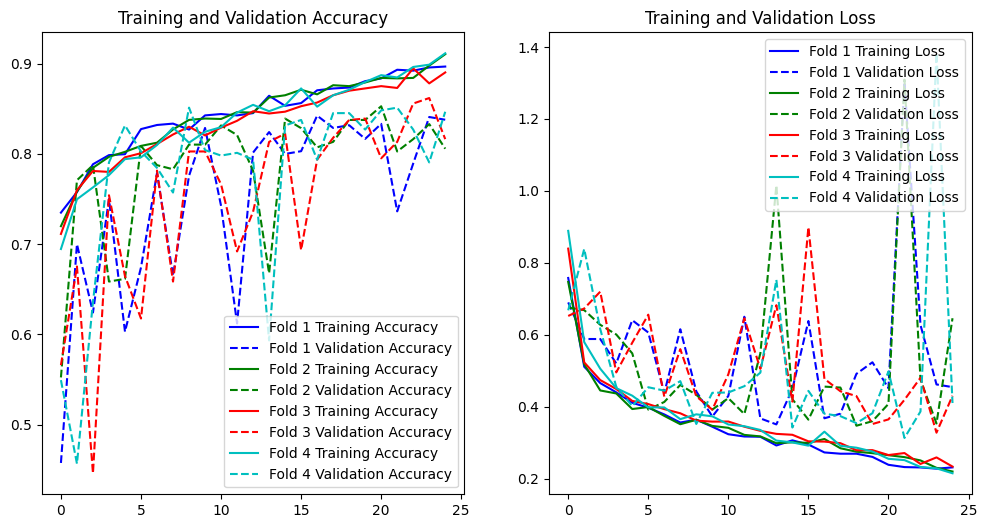

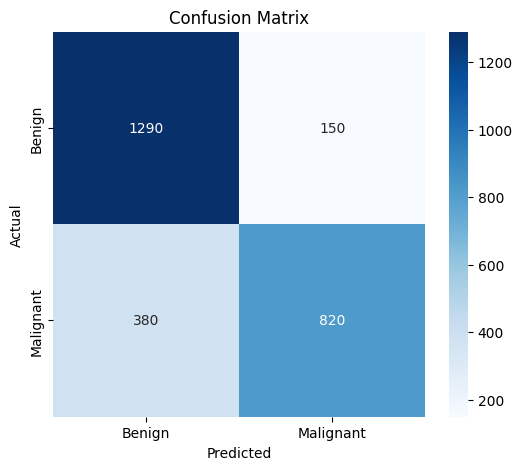

In [ ]:
model_obj = ImageClassificationModel(optimizer='RMSprop',
                                     loss_function='categorical_crossentropy',
                                     activation_function='relu',
                                     output_activation_function='softmax',
                                     batch_size=32,
                                     epochs=25,
                                     num_output_neurons=2,
                                     num_folds=4)
model_obj.run()

Using the same architecture from lab4 with the cifar-10 example, only modifying it for an output of 2 categories (benign and malignant) instead of the 10 classes, we only achieved an accuracy of 0.5808. A very poor result.

#**Test Other Configurations**

Looking at the literature around the subject of CNN's, we found that:


*   Adam as optimizer is almost always the better choice. This is due to the fact it uses the advantages provided by both AdaGrad and RMSProp namely
*   Binary cross entropy is the best choice for our binary classification problem
*   ReLu is the best activation function in most larger models using CNN. We will test some different versions of this, like leaky relu.

Sources for this information are found here:

Kingma, D. P. (2014). Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980.

Ruby, U., & Yendapalli, V. (2020). Binary cross entropy with deep learning technique for image classification. Int. J. Adv. Trends Comput. Sci. Eng, 9(10).

Lapid, R., & Sipper, M. (2022, July). Evolution of activation functions for deep learning-based image classification. In Proceedings of the genetic and evolutionary computation conference companion (pp. 2113-2121).



We will use these configuration options as default for the next tests. We will try different configurations by changing:

*   Batch size
*   Strides
*   Dilation
*   Data Augmentation
*   activation functions (for hidden layers)

We define 25 epochs to be the default to make sure we get a consistent result while not spending too much time optimizing the weights.

Finally, we went for 4-fold cross validation, as 3-fold validation still gave relatively inconsistent results and more than 4 resulted in high compute times.



In [ ]:
TEST_OPTIMIZER = 'adam'
TEST_LOSS_FUNCTION = 'binary_crossentropy'
TEST_ACTIVATION_FUNCTION = 'relu'
TEST_EPOCHS = 25
TEST_FOLDS = 4

**Batch Size**

We start by optimizing the batch size configuration. From the paper that is listed below, we found a range of 32 to 128 to be optimal for generalization vs. computational resources required. We included a batch size of 16 to see what the impact on the result would be. The results can be found in the graphs below the code blocks.

Lapid, R., & Sipper, M. (2022, July). Evolution of activation functions for deep learning-based image classification. In Proceedings of the genetic and evolutionary computation conference companion (pp. 2113-2121).

**Batch Size = 16**

Fold 1 - Validation Loss: 0.7561, Validation Accuracy: 0.7591
Fold 2 - Validation Loss: 0.3063, Validation Accuracy: 0.8604
Fold 3 - Validation Loss: 0.3307, Validation Accuracy: 0.8407
Fold 4 - Validation Loss: 0.3762, Validation Accuracy: 0.8179
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

Overall Metrics Across All Folds:
Accuracy: 0.8220
Precision: 0.8367
Recall: 0.7542
F1 Score: 0.7933


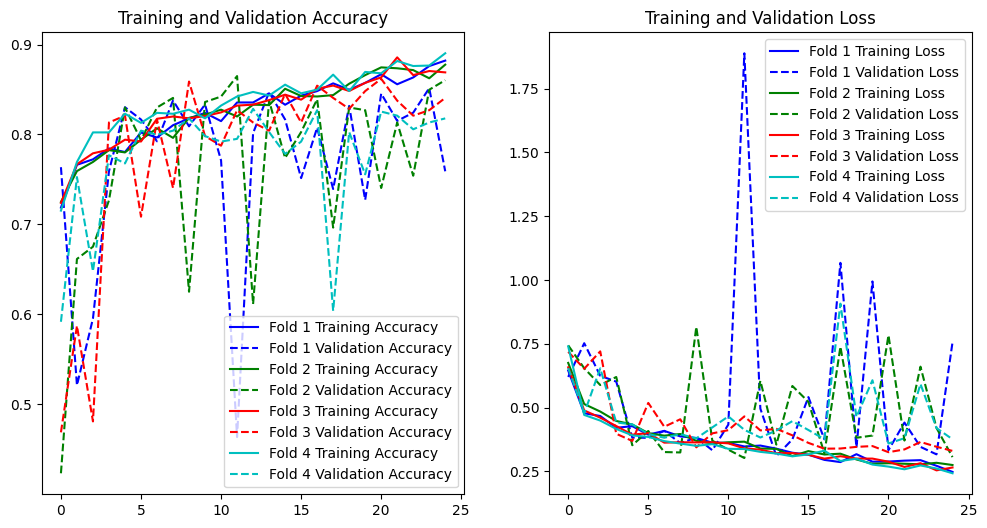

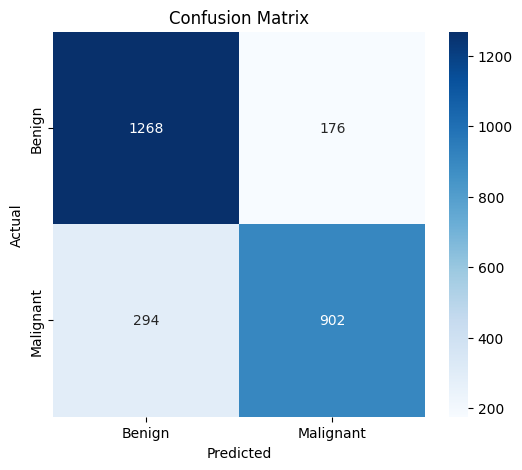

In [ ]:
model_obj = ImageClassificationModel(
    optimizer=TEST_OPTIMIZER,
    loss_function=TEST_LOSS_FUNCTION,
    activation_function=TEST_ACTIVATION_FUNCTION,
    output_activation_function='sigmoid',
    batch_size=16, epochs=TEST_EPOCHS,
    num_output_neurons=1,
    num_folds=TEST_FOLDS)

model_obj.run()

**batch size 32**

Fold 1 - Validation Loss: 0.5159, Validation Accuracy: 0.8197
Fold 2 - Validation Loss: 0.3988, Validation Accuracy: 0.7967
Fold 3 - Validation Loss: 0.4004, Validation Accuracy: 0.8179
Fold 4 - Validation Loss: 0.5854, Validation Accuracy: 0.7936
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Overall Metrics Across All Folds:
Accuracy: 0.8098
Precision: 0.7500
Recall: 0.8418
F1 Score: 0.7932


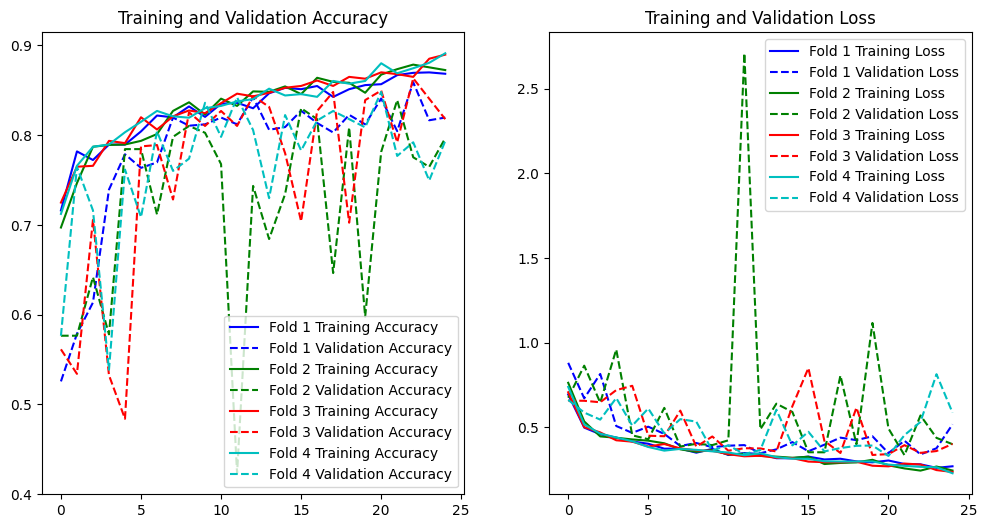

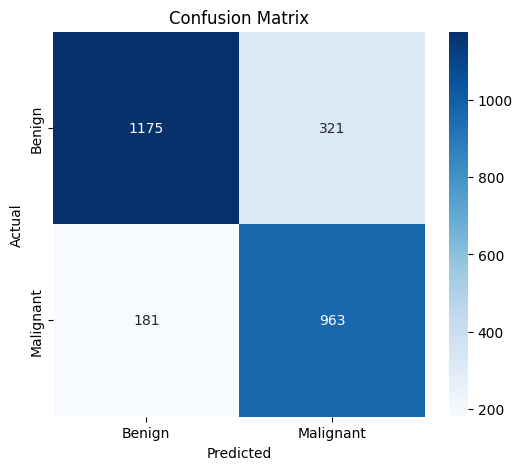

In [ ]:
model_obj = ImageClassificationModel(
    optimizer=TEST_OPTIMIZER,
    loss_function=TEST_LOSS_FUNCTION,
    activation_function=TEST_ACTIVATION_FUNCTION,
    output_activation_function='sigmoid',
    batch_size=32, epochs=TEST_EPOCHS,
    num_output_neurons=1,
    num_folds=TEST_FOLDS)

model_obj.run()

**Batch Size = 64**

Fold 1 - Validation Loss: 0.4122, Validation Accuracy: 0.8152
Fold 2 - Validation Loss: 0.4410, Validation Accuracy: 0.8255
Fold 3 - Validation Loss: 0.2990, Validation Accuracy: 0.8483
Fold 4 - Validation Loss: 0.3654, Validation Accuracy: 0.8240
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Overall Metrics Across All Folds:
Accuracy: 0.8303
Precision: 0.8328
Recall: 0.7933
F1 Score: 0.8126


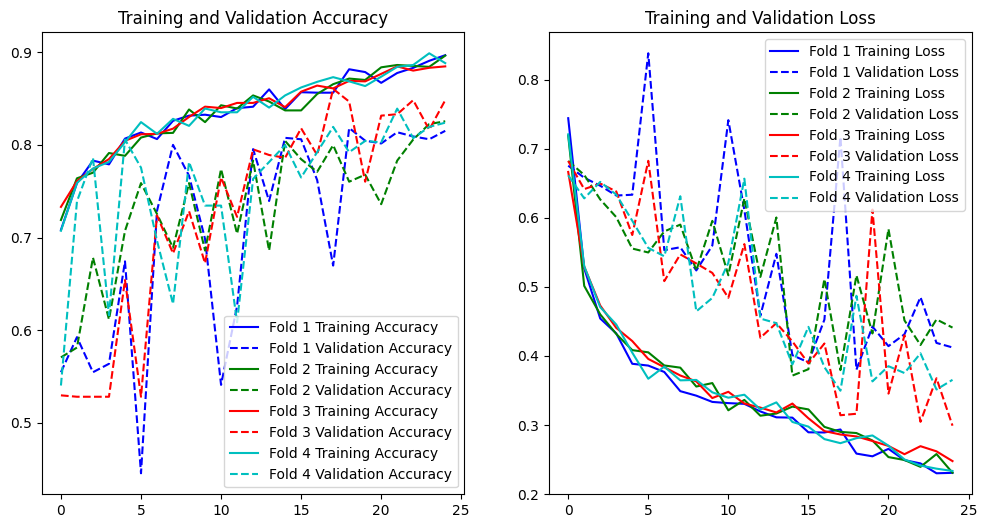

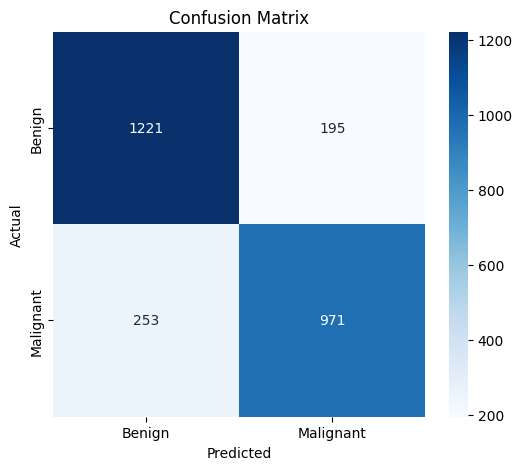

In [ ]:
model_obj = ImageClassificationModel(
    optimizer=TEST_OPTIMIZER,
    loss_function=TEST_LOSS_FUNCTION,
    activation_function=TEST_ACTIVATION_FUNCTION,
    output_activation_function='sigmoid',
    batch_size=64, epochs=TEST_EPOCHS,
    num_output_neurons=1,
    num_folds=TEST_FOLDS)

model_obj.run()

**Batch Size = 128**

Fold 1 - Validation Loss: 0.3728, Validation Accuracy: 0.8364
Fold 2 - Validation Loss: 0.8311, Validation Accuracy: 0.6176
Fold 3 - Validation Loss: 0.4213, Validation Accuracy: 0.7754
Fold 4 - Validation Loss: 0.5527, Validation Accuracy: 0.7527
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Overall Metrics Across All Folds:
Accuracy: 0.7625
Precision: 0.7067
Recall: 0.7491
F1 Score: 0.7273


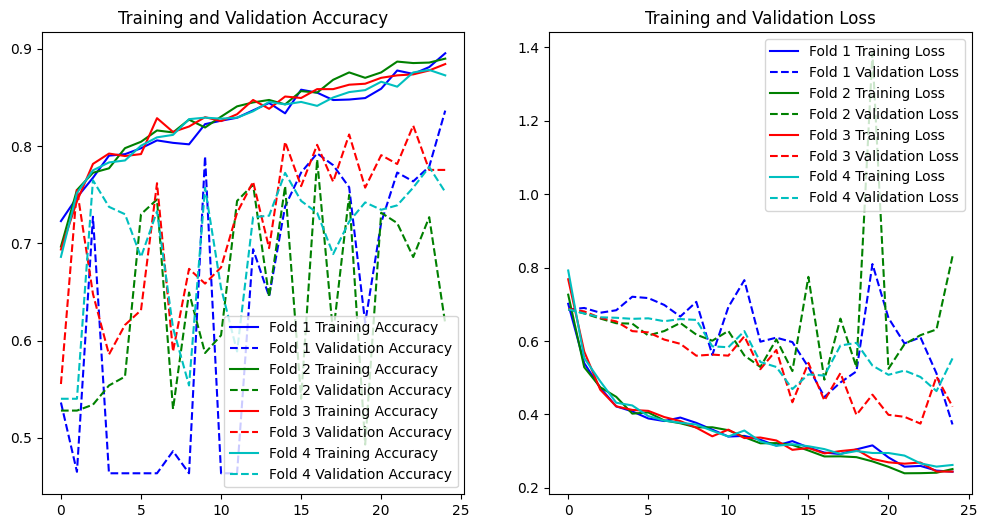

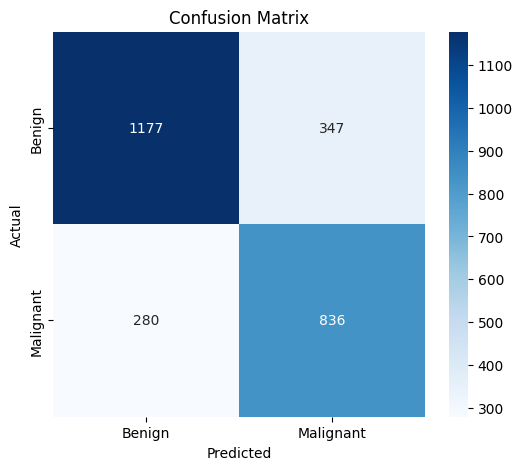

In [ ]:
model_obj = ImageClassificationModel(
    optimizer=TEST_OPTIMIZER,
    loss_function=TEST_LOSS_FUNCTION,
    activation_function=TEST_ACTIVATION_FUNCTION,
    output_activation_function='sigmoid',
    batch_size=128, epochs=TEST_EPOCHS,
    num_output_neurons=1,
    num_folds=TEST_FOLDS)

model_obj.run()

In the end the most stable batch size had a size of 64. Any higher and lower would result in more inconsistent results. We therefore continue our testing with the batch size set to 64.

In [ ]:
TEST_BATCH_SIZE = 64

**Strides**

Until now we have used a default value of (2,2) for the strides. In this section, we will see if using a smaller dimension (1,1) improves the model's performance enough to justify the longer running times.

**Default (2,2) dimension**

Fold 1 - Validation Loss: 0.4662, Validation Accuracy: 0.8000
Fold 2 - Validation Loss: 0.3507, Validation Accuracy: 0.8179
Fold 3 - Validation Loss: 0.5013, Validation Accuracy: 0.7724
Fold 4 - Validation Loss: 0.3902, Validation Accuracy: 0.8270
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Overall Metrics Across All Folds:
Accuracy: 0.8008
Precision: 0.7623
Recall: 0.8427
F1 Score: 0.8005


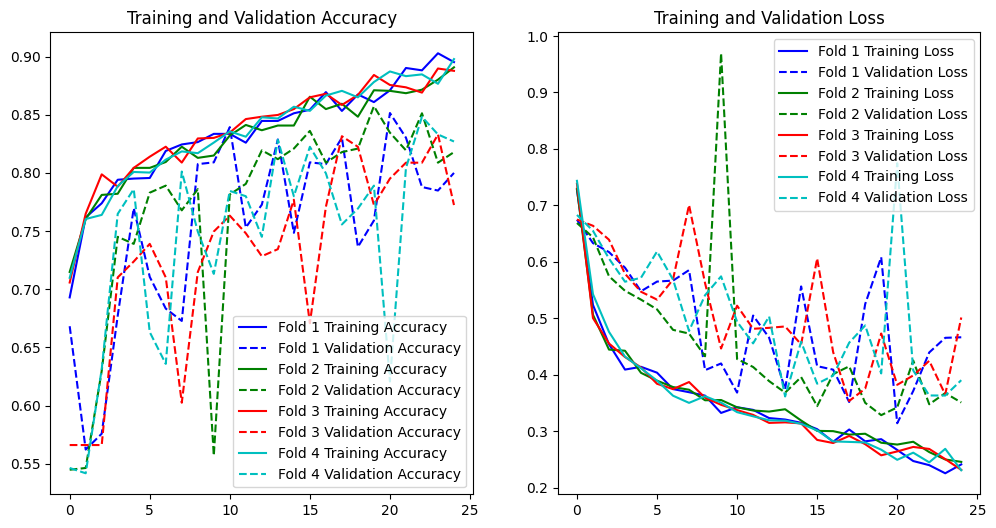

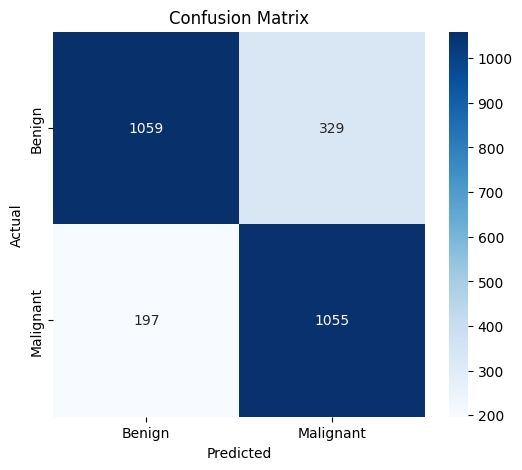

In [ ]:
model_obj = ImageClassificationModel(
    optimizer=TEST_OPTIMIZER,
    loss_function=TEST_LOSS_FUNCTION,
    activation_function=TEST_ACTIVATION_FUNCTION,
    output_activation_function='sigmoid',
    batch_size=TEST_BATCH_SIZE, epochs=TEST_EPOCHS,
    num_output_neurons=1,
    strides=(2, 2),
    num_folds=TEST_FOLDS)

model_obj.run()

**(1,1) dimension**


Fold 1 - Validation Loss: 0.5538, Validation Accuracy: 0.7864
Fold 2 - Validation Loss: 0.4003, Validation Accuracy: 0.8194
Fold 3 - Validation Loss: 0.4504, Validation Accuracy: 0.8164
Fold 4 - Validation Loss: 0.5288, Validation Accuracy: 0.8134
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

Overall Metrics Across All Folds:
Accuracy: 0.8167
Precision: 0.7888
Recall: 0.8274
F1 Score: 0.8076


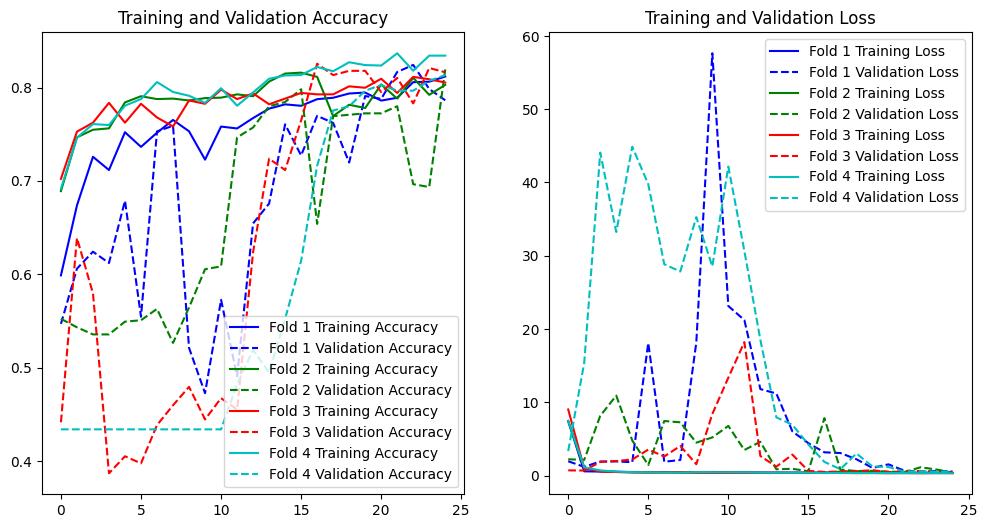

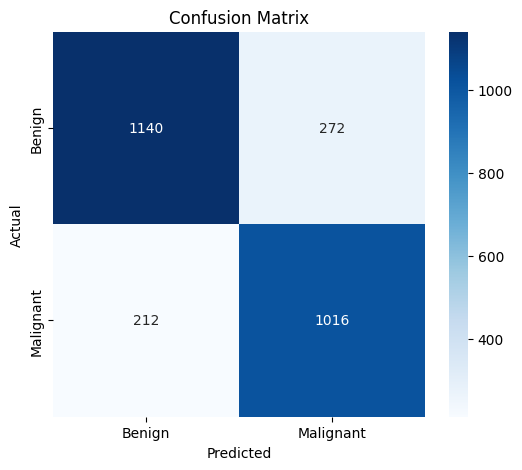

In [ ]:
model_obj = ImageClassificationModel(
    optimizer=TEST_OPTIMIZER,
    loss_function=TEST_LOSS_FUNCTION,
    activation_function=TEST_ACTIVATION_FUNCTION,
    output_activation_function='sigmoid',
    batch_size=TEST_BATCH_SIZE, epochs=TEST_EPOCHS,
    num_output_neurons=1,
    strides=(1, 1),
    num_folds=TEST_FOLDS)

model_obj.run()

Using a smaller dimension did not improve performance enough to justify the longer running times. Therefore, we will continue using the (2, 2) dimension from now on.

In [ ]:
TEST_STRIDES = (2, 2)

**Dilation**

Until now we have used a (1,1) dilation, which means that our filter only used the nearest pixels to find patterns in the data. Using a bigger dilation can result in better performance while keeping the computational intensity the same.

Fold 1 - Validation Loss: 0.3662, Validation Accuracy: 0.8167
Fold 2 - Validation Loss: 0.3516, Validation Accuracy: 0.8346
Fold 3 - Validation Loss: 0.6226, Validation Accuracy: 0.7860
Fold 4 - Validation Loss: 0.4494, Validation Accuracy: 0.7967
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Overall Metrics Across All Folds:
Accuracy: 0.8091
Precision: 0.7862
Recall: 0.8080
F1 Score: 0.7969


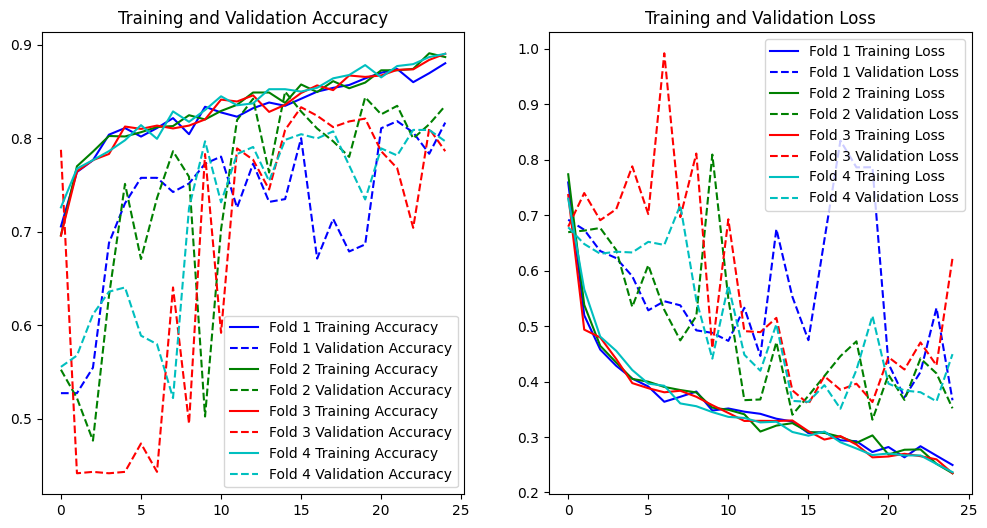

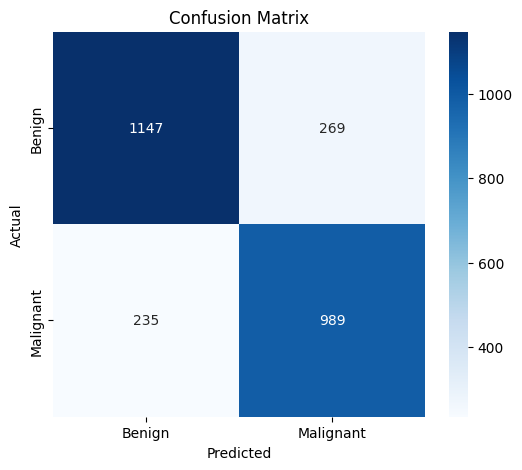

In [ ]:
model_obj = ImageClassificationModel(
    optimizer=TEST_OPTIMIZER,
    loss_function=TEST_LOSS_FUNCTION,
    activation_function=TEST_ACTIVATION_FUNCTION,
    output_activation_function='sigmoid',
    batch_size=TEST_BATCH_SIZE, epochs=TEST_EPOCHS,
    num_output_neurons=1,
    strides=TEST_STRIDES,
    dilation=(1,1),
    num_folds=TEST_FOLDS)

model_obj.run()

Fold 1 - Validation Loss: 0.5873, Validation Accuracy: 0.7455
Fold 2 - Validation Loss: 0.4483, Validation Accuracy: 0.7800
Fold 3 - Validation Loss: 0.4398, Validation Accuracy: 0.8452
Fold 4 - Validation Loss: 0.9594, Validation Accuracy: 0.7633
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

Overall Metrics Across All Folds:
Accuracy: 0.7943
Precision: 0.7381
Recall: 0.8462
F1 Score: 0.7885


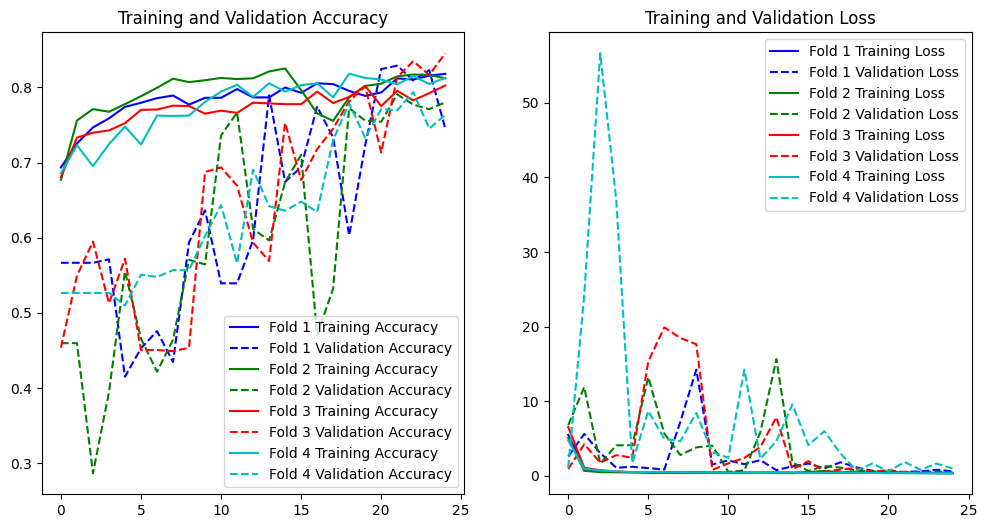

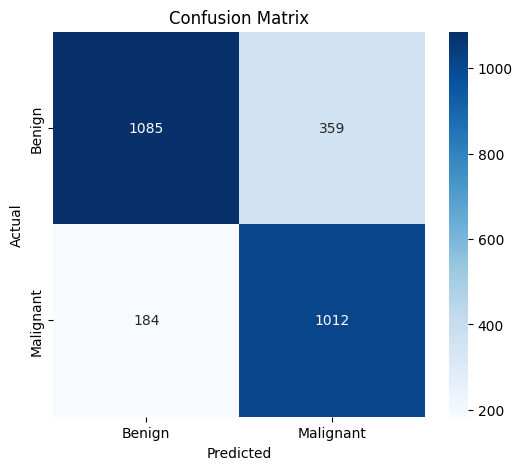

In [ ]:
model_obj = ImageClassificationModel(
    optimizer=TEST_OPTIMIZER,
    loss_function=TEST_LOSS_FUNCTION,
    activation_function=TEST_ACTIVATION_FUNCTION,
    output_activation_function='sigmoid',
    batch_size=TEST_BATCH_SIZE, epochs=TEST_EPOCHS,
    num_output_neurons=1,
    strides=(1,1),
    dilation=(2,2),
    num_folds=TEST_FOLDS)

model_obj.run()

Using a dilation of (2,2) did not improve the results so we will stick to the default (1,1) dilation from this moment on.

**Data Augmentation**

For data augmentation we apply some data-modifying classes to attempt to artifically increase its size, using flipping, both horizontal and vertical. We hypothesized that an image of skin cancer, or a skin spot does not have a correct orientation, thus this would work well. We also though that the zoom range would work well, since the image may as well have been taken from closer, or further away.

In [ ]:
datagen_1 = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 585ms/step - accuracy: 0.6673 - loss: 0.8652 - val_accuracy: 0.5485 - val_loss: 0.6797
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 481ms/step - accuracy: 0.7683 - loss: 0.5054 - val_accuracy: 0.5485 - val_loss: 0.6572
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 483ms/step - accuracy: 0.7680 - loss: 0.4682 - val_accuracy: 0.5485 - val_loss: 0.7224
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 481ms/step - accuracy: 0.7762 - loss: 0.4307 - val_accuracy: 0.5985 - val_loss: 0.6036
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 481ms/step - accuracy: 0.7944 - loss: 0.4327 - val_accuracy: 0.5955 - val_loss: 0.6419
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 482ms/step - accuracy: 0.8064 - loss: 0.4035 - val_accuracy: 0.7576 - val_loss: 0.4967
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 482ms/step - accuracy: 0.7958 - loss: 0.4192 - val_accuracy: 0.7667 - val_loss: 0.4827
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 481ms/step - accuracy: 0.8187 - loss: 0.3823 - val_accuracy: 0.745

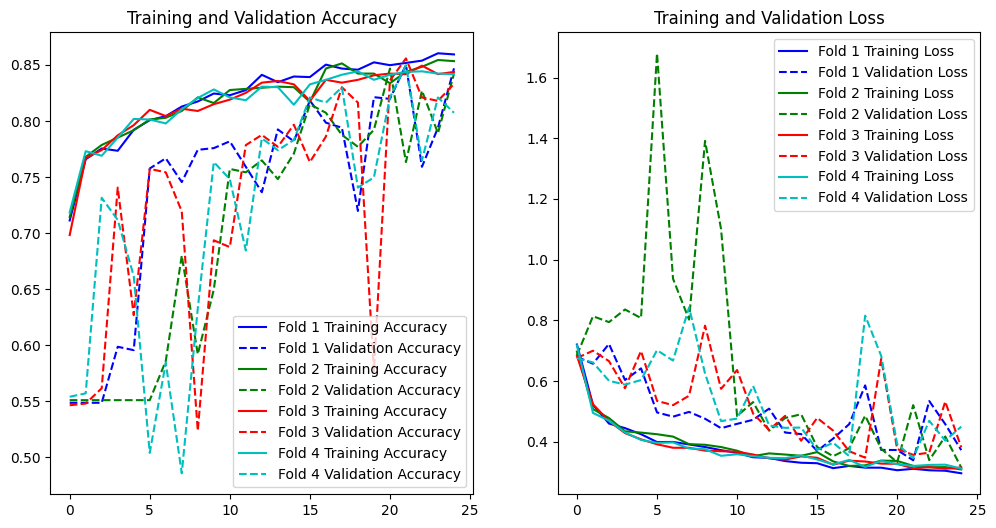

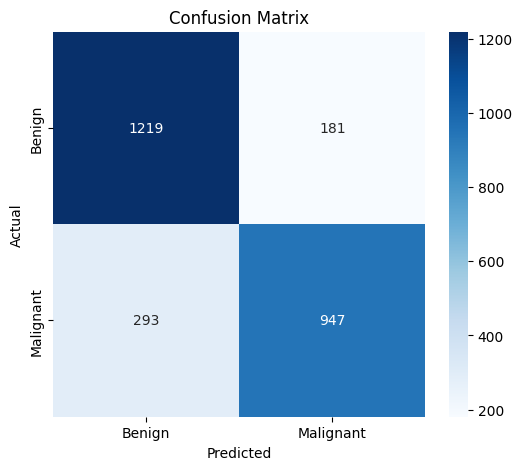

In [ ]:
from tensorflow.keras.layers import LeakyReLU

model_obj = ImageClassificationModel(
    optimizer=TEST_OPTIMIZER,
    loss_function=TEST_LOSS_FUNCTION,
    activation_function=TEST_ACTIVATION_FUNCTION,
    output_activation_function='sigmoid',
    dilation=(1,1),
    strides=TEST_STRIDES,
    batch_size=TEST_BATCH_SIZE, epochs=TEST_EPOCHS,
    data_augmentation=datagen_1,
    num_output_neurons=1,
    num_folds=TEST_FOLDS)

model_obj.show_training_progress()
model_obj.run()

This data augmentation gave us a little improvement overall.

Perhaps adding more augmentation would yield even better results?

Therefore, we tried adding width and height shifts, with a maximum of 10%.

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 32s 641ms/step - accuracy: 0.6205 - loss: 0.9504 - val_accuracy: 0.5621 - val_loss: 0.6851
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 504ms/step - accuracy: 0.7526 - loss: 0.5858 - val_accuracy: 0.5409 - val_loss: 0.6831
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 507ms/step - accuracy: 0.7432 - loss: 0.5275 - val_accuracy: 0.7606 - val_loss: 0.6613
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 503ms/step - accuracy: 0.7681 - loss: 0.4653 - val_accuracy: 0.6030 - val_loss: 0.6649
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 505ms/step - accuracy: 0.7721 - loss: 0.4521 - val_accuracy: 0.4773 - val_loss: 0.6880
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 504ms/step - accuracy: 0.7874 - loss: 0.4248 - val_accuracy: 0.4621 - val_loss: 0.7282
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 504ms/step - accuracy: 0.8005 - loss: 0.4141 - val_accuracy: 0.4788 - val_loss: 0.7363
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 504ms/step - accuracy: 0.8101 - loss: 0.3978 - val_accuracy: 0.592

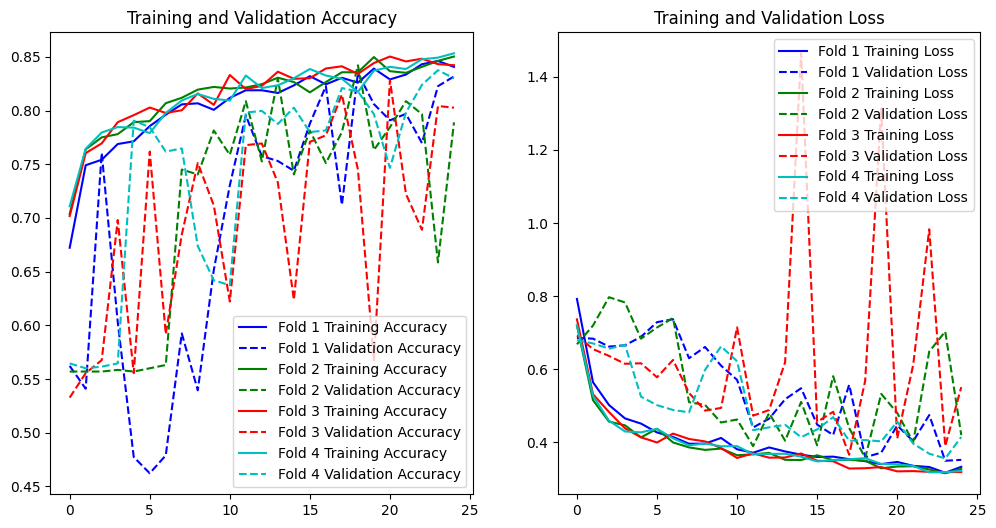

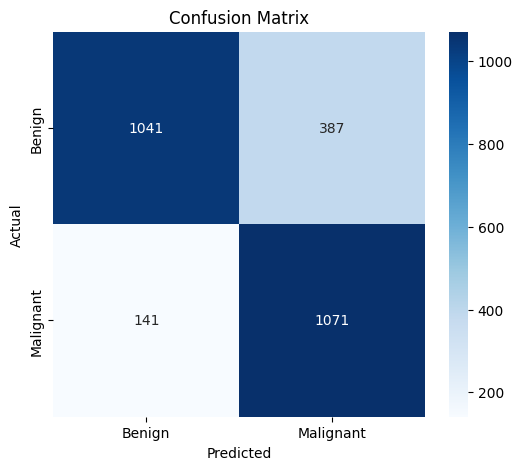

In [ ]:
from tensorflow.keras.layers import LeakyReLU

datagen_2 = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

model_obj = ImageClassificationModel(
    optimizer=TEST_OPTIMIZER,
    loss_function=TEST_LOSS_FUNCTION,
    activation_function=TEST_ACTIVATION_FUNCTION,
    output_activation_function='sigmoid',
    dilation=(1,1),
    strides=TEST_STRIDES,
    batch_size=TEST_BATCH_SIZE, epochs=TEST_EPOCHS,
    data_augmentation=datagen_2,
    num_output_neurons=1,
    num_folds=TEST_FOLDS)

model_obj.run()

This did not improve performance. We hypothesize that this could be due to the empty space or missing data introduced when an image is shifted. We will use the first data augmentation from this point on.

**Leaky ReLu**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 1 - Validation Loss: 0.3260, Validation Accuracy: 0.8424
Fold 2 - Validation Loss: 0.4096, Validation Accuracy: 0.8134
Fold 3 - Validation Loss: 0.3181, Validation Accuracy: 0.8483
Fold 4 - Validation Loss: 0.3172, Validation Accuracy: 0.8437
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Overall Metrics Across All Folds:
Accuracy: 0.8451
Precision: 0.8037
Recall: 0.8294
F1 Score: 0.8163


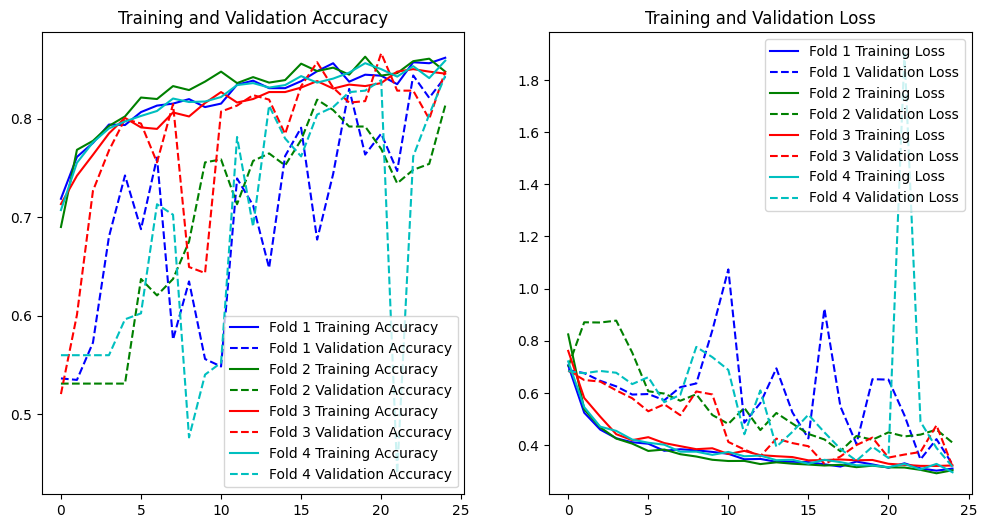

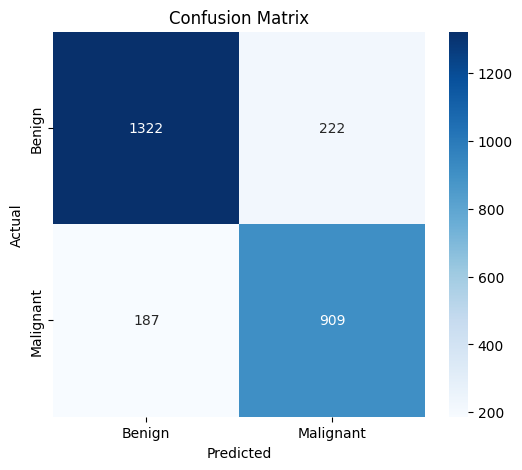

In [ ]:
from tensorflow.keras.layers import LeakyReLU

model_obj = ImageClassificationModel(
    optimizer=TEST_OPTIMIZER,
    loss_function=TEST_LOSS_FUNCTION,
    activation_function=LeakyReLU(alpha=0.01),
    output_activation_function='sigmoid',
    dilation=(1,1),
    strides=TEST_STRIDES,
    batch_size=TEST_BATCH_SIZE, epochs=TEST_EPOCHS,
    num_output_neurons=1,
    data_augmentation=datagen_1,
    num_folds=TEST_FOLDS)

model_obj.run()

Changing to leaky relu over relu improved performance a bit more, resulting in our best run till now.

Here we are testing with fewer epochs (10), so that we can compare the results between 10 and 25 epochs.

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 1 - Validation Loss: 0.4776, Validation Accuracy: 0.7621
Fold 2 - Validation Loss: 0.4979, Validation Accuracy: 0.7542
Fold 3 - Validation Loss: 0.4823, Validation Accuracy: 0.7572
Fold 4 - Validation Loss: 0.4557, Validation Accuracy: 0.7754
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Overall Metrics Across All Folds:
Accuracy: 0.7561
Precision: 0.6935
Recall: 0.8072
F1 Score: 0.7461


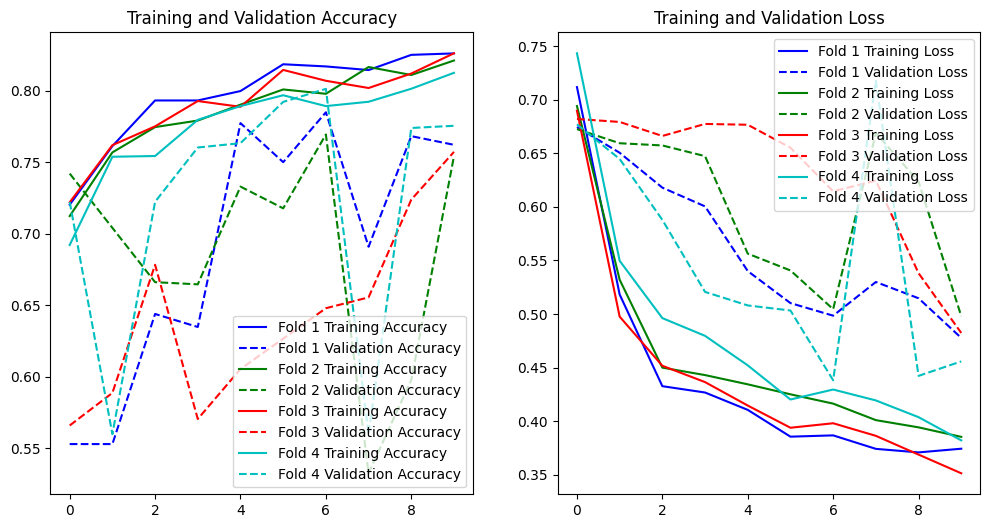

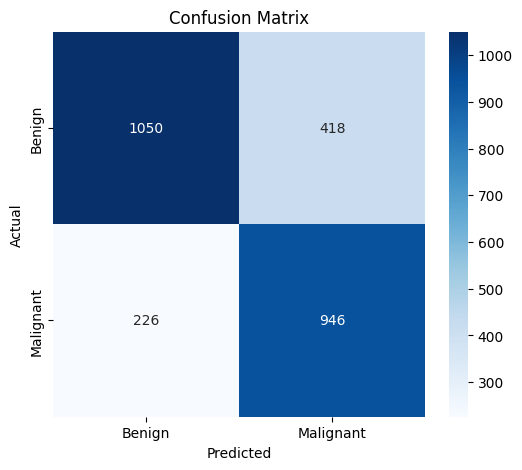

In [ ]:
from tensorflow.keras.layers import LeakyReLU

model_obj = ImageClassificationModel(
    optimizer=TEST_OPTIMIZER,
    loss_function=TEST_LOSS_FUNCTION,
    activation_function=LeakyReLU(alpha=0.01),
    output_activation_function='sigmoid',
    dilation=(1,1),
    strides=TEST_STRIDES,
    batch_size=TEST_BATCH_SIZE, epochs=10,
    num_output_neurons=1,
    data_augmentation=datagen_1,
    num_folds=TEST_FOLDS)

model_obj.run()

The performance is much worse with 10 epochs, indicating severe underfitting. And we suspect that even with our standard of 25 epochs, we are still underfitting.
But we are not able to try with many more epochs to look for the optimal number of epochs, or potential overfitting, since we dont have enough computational power for it.

Therefore we will use the 25 epoch version as our final model.

# Results
## Architecture
As previoulsy mentioned, we are using the architecure from lab4, this means that we are using the following layers:
- input layer of size 228x228x3 (our modification) (start of first block)
- convolutional layer with 32 filters/kernels (relu)
- Batch normalization
- maxpooling (2, 2)
- Dropout 0.2
- Convolutional layer with 64 filters/kernels (relu) (start of second block)
- Batch normalization
- Convolutional layer with 64 filters/kernels (relu)
- Batch normalization
- maxpooling (2, 2)
- Dropout 0.3
- Convolutional layer with 128 filters/kernels (relu) (start of third block)
- Batch normalization
- Convolutional layer with 128 filters/kernels (relu)
- Batch normalization
- maxpooling (2, 2)
- Dropout 0.4
- Dense layer 128 neurons (relu)
- output layer 1 neuron (sigmoid) (our modification)

## Hyper parameters
In the end we decided on the following settings as they performed the best for us:
- Optimizer: Adam
- Loss function: binary cross entropy
- Activation: leaky relu
- dilation: none
- stride: 2
- batch size: 64
- 4 fold cross validation
- 50 epochs
- data augmentation: horizontal_flip, vertical_flip, zoom

Using these settings we were able to achieve the following performance:
- Accuracy: 0.8451
- Precision: 0.8037
- Recall: 0.8294
- F1 Score: 0.8163

This accuracy is still somewhat low, especially for a medical setting. Also because we got a large number of false negatives. I think part of our moderate results are the small slightly unbalanced dataset. The differences between benign and malignant samples are also very minor, as can be seen in the heatmap comparison between the two.

Provided we had more time, the following could be experimented with to improve performance:
- Account for the class imbalance by either discarding excess images, or introducing weighted binary cross entrpy.
- Train using longer epochs, this was hard for us, due to the limited computational power we had available.
- A deeper network, due to the varied data, where two opposite samples could have more similarities than two of the same; having a deeper network would hopefully allow it to learn some higher-level features.